In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import requests

import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
#USPTO Trademark Document Search (v1)
r = requests.get('https://developer.uspto.gov/ibd-api/v1/trademark/documents?text=cat%20three%20gears&classCode=020&start=0&rows=10')

In [3]:
#Explore the response JSON
resp = r.json()
resp_list = resp['response']['docs']
print(resp_list[0].keys())
print(resp_list[3]['uspto_tm_document']['trademark_case_files']['trademark_case_file']['case_file_header']['mark'].keys())

[u'tsdrImageLarge', u'tsdrImageOriginal', u'tsdrImageTiny', u'archiveUrl', u'uspto_tm_document', u'tsdrPdfBundle', u'_version_', u'tsdrZipBundle', u'id', u'tsdrStatusUrl']
[u'action_code', u'version', u'typed_mark']


In [4]:
serial_nos = []
for i, app in enumerate(resp_list):
    cfh = app['uspto_tm_document']['trademark_case_files']['trademark_case_file']['case_file_header']
    if 'design_mark' in cfh['mark'].keys():
        #print(i)
        serial_nos.append(cfh['serial_number'])
print(serial_nos)

[87368206, 87434394, 87928270, 87410724]


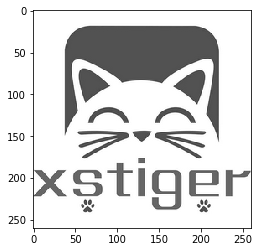

In [5]:
#Retrieve design mark image file
url_base = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_nos[1])

tm_image = imageio.imread(url_base)
imshow(tm_image)

### L1 Norm (Basic Image Similarity Metric) [For comparison w/ NST metrics later]

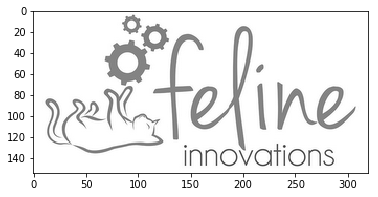

In [6]:
#Calculate L1 norm [CREATE FUNCTION]

url_base2 = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_nos[0])
tm_image2 = imageio.imread(url_base2)
imshow(tm_image2)

In [7]:
tm_image2.shape

(155, 320, 3)

(155, 320, 3)
(255, 420, 3)


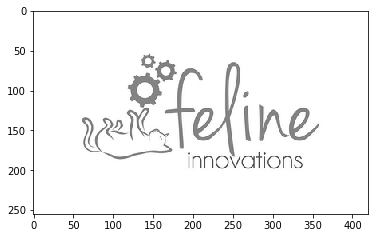

In [8]:
tm_image2_padded = np.pad(tm_image2, ((50,50),(50,50),(0,0)), 'constant', constant_values=(255,255))
print(tm_image2.shape)
print(tm_image2_padded.shape)
imshow(tm_image2_padded)
#print(tm_image2.shape)
#imshow(tm_image2)

In [9]:
def half_ceil(x):
    return (np.ceil(x / 2.0)).astype(int)

In [10]:
def half_floor(x):
    return (np.floor(x / 2.0)).astype(int)

In [11]:
def reshape_images_to_same_shape(img1, img2):
    img1_xpad = 0
    img1_ypad = 0
    img2_xpad = 0
    img2_ypad = 0
    
    x_pad = img2.shape[0] - img1.shape[0]
    if (x_pad > 0): #img2 larger in x dim => pad img1
        img1_xpad = x_pad
    else:
        img2_xpad = -x_pad
        
    y_pad = img2.shape[1] - img1.shape[1]
    if (y_pad > 0): #img2 larger in y dim => pad img1
        img1_ypad = y_pad
    else:
        img2_ypad = -y_pad
    
    #img1_pad = np.pad(img1, (((np.ceil(img1_xpad / 2.0).astype(int)), (np.floor(img1_xpad / 2.0).astype(int))),((np.ceil(img1_ypad / 2.0).astype(int)), (np.floor(img1_ypad / 2.0).astype(int))), (0,0)), 'constant', constant_values=(255,255))
    #img2_pad = np.pad(img2, (((np.ceil(img2_xpad / 2.0).astype(int)), (np.floor(img2_xpad / 2.0).astype(int))),((np.ceil(img2_ypad / 2.0).astype(int)), (np.floor(img2_ypad / 2.0).astype(int))), (0,0)), 'constant', constant_values=(255,255))
    
    img1_pad = np.pad(img1, ((half_ceil(img1_xpad), half_floor(img1_xpad)),(half_ceil(img1_ypad), half_floor(img1_ypad)), (0,0)), 'constant', constant_values=(255,255))
    img2_pad = np.pad(img2, ((half_ceil(img2_xpad), half_floor(img2_xpad)),(half_ceil(img2_ypad), half_floor(img2_ypad)), (0,0)), 'constant', constant_values=(255,255))
    
    return(img1_pad, img2_pad)

In [12]:
pimg1, pimg2 = reshape_images_to_same_shape(tm_image, tm_image2)
print(tm_image.shape, pimg1.shape)
print(tm_image2.shape, pimg2.shape)

((260, 260, 3), (260, 320, 3))
((155, 320, 3), (260, 320, 3))


In [13]:
#L1 norm - simple metric for image similarity (http://web.mit.edu/sinhalab/Papers/sinha_russell2011.pdf)
print(np.sum(np.abs(pimg1 - pimg2))) #Not particularly illuminating. [Divide by # pixels to normalize?]

12340902


In [14]:
def calc_L1_dist(img1, img2):
    assert img1.shape == img2.shape, 'Images must have the same shape!'
    return (np.sum(np.abs(img1 - img2))) / (img1.shape[0] * img1.shape[1])

In [15]:
print(calc_L1_dist(pimg1, pimg2))
#Normalized by # of pixels -> value from 0 to 255

148.32814903846153


In [16]:
pimg1_1, pimg1_1 = reshape_images_to_same_shape(tm_image, tm_image)
print(calc_L1_dist(pimg1_1, pimg1_1)) #0, as expected

0.0


(155, 320)


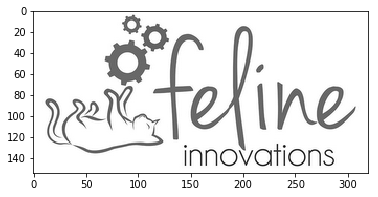

In [17]:
from skimage import io
sk_img = io.imread(url_base2, as_gray=True)
print(sk_img.shape)
imshow(sk_img, cmap='gray')

## Content & Style Similarity (From Neural Style Transfer)

### Content

In [18]:
#Most design marks are registered in grayscale... but sometimes color is important
#Convert everything to grayscale for now, but TODO:
#for color registered marks, compare color AS WELL AS grayscale representations

In [19]:
import tensorflow as tf
from nst_utils import *

In [20]:
#Use the VGG model from the original Neural Style Transfer (NST) paper: https://arxiv.org/abs/1508.06576
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

Instructions for updating:
Colocations handled automatically by placer.
{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256

In [21]:
def load_model():
    return load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [22]:
def compute_content_cost(a_I, a_C):
    """
    Computes the content cost
    
    Arguments:
    a_I -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image I (input) 
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C (compare)
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_C (≈1 line)
    m, n_H, n_W, n_C = a_C.shape
    
    # Reshape a_I and a_C (≈2 lines)
    a_I_unrolled = np.reshape(a_I, [n_H * n_W, n_C])
    a_C_unrolled = np.reshape(a_C, [n_H * n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1.0 / (4 * n_H * n_W * n_C)) * np.sum(np.square(np.subtract(a_I_unrolled, a_C_unrolled)))
    
    return J_content

In [23]:
def get_content_activation(img):
    # Reset the graph
    tf.reset_default_graph()

    #Reload the model
    model = load_model()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        sess.run(model['input'].assign(img))
        out = model['conv4_2']
        a = sess.run(out)

        return a

In [24]:
def pad_to_300_400(img):
    img_xpad = 300 - img.shape[0]
    img_ypad = 400 -img.shape[1]
    img_pad = np.pad(img, ((half_ceil(img_xpad), half_floor(img_xpad)),(half_ceil(img_ypad), half_floor(img_ypad)), (0,0)), 'constant', constant_values=(255,255))
    return img_pad

In [25]:
test_imgx = reshape_and_normalize_image(pad_to_300_400(tm_image))
print(tm_image.shape, test_imgx.shape)

((260, 260, 3), (1, 300, 400, 3))


In [26]:
test_imgx2 = reshape_and_normalize_image(pad_to_300_400(tm_image2))
print(tm_image2.shape, test_imgx2.shape)

((155, 320, 3), (1, 300, 400, 3))


In [27]:
a1 = get_content_activation(test_imgx)
#print(a1)

In [28]:
a2 = get_content_activation(test_imgx2)
#print(a2)

In [29]:
print(compute_content_cost(a1, a2)) #Prev: 13921.264000000001 [conv2_2] | 14887.86 [conv4_2]

14887.861052631579


### Style

In [30]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = np.matmul(A, np.transpose(A))
    
    return GA

In [31]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.shape
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = np.transpose(np.reshape(a_S, [n_H * n_W, n_C]))
    a_G = np.transpose(np.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1.0 / (4 * n_C * n_C * n_H * n_H * n_W * n_W)) * np.sum(np.square(np.subtract(GS, GG)))
    
    return J_style_layer

In [32]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [33]:
def get_style_activations(img):
    # Reset the graph
    tf.reset_default_graph()

    #Reload the model
    model = load_model()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        sess.run(model['input'].assign(img))
        style_activations = []

        for layer_name, _ in STYLE_LAYERS:
            out = model[layer_name]
            style_activations.append(sess.run(out))

        return style_activations

In [34]:
def sum_layer_style_costs(style_activations_1, style_activations_2):
    assert len(style_activations_1) == len(style_activations_2)
    
    total_style_cost = 0
    
    for i, activation in enumerate(style_activations_1):
        _, coeff = STYLE_LAYERS[i]
        total_style_cost += (coeff * compute_layer_style_cost(style_activations_1[i], style_activations_2[i]))
    
    return total_style_cost

In [35]:
style_activs_1 = get_style_activations(test_imgx)
#print(style_activs_1)

In [36]:
style_activs_2 = get_style_activations(test_imgx2)
#print(style_activs_2)

In [37]:
print(sum_layer_style_costs(style_activs_1, style_activs_2))

21065966.996102605


In [38]:
def get_content_score(img1, img2):
    
    #Process images 
    proc_img1 = reshape_and_normalize_image(pad_to_300_400(img1))
    proc_img2 = reshape_and_normalize_image(pad_to_300_400(img2))
    
    #Get activations
    a1 = get_content_activation(proc_img1)
    a2 = get_content_activation(proc_img2)
    
    return compute_content_cost(a1, a2)

In [39]:
def get_style_score(img1, img2):
    
    #Process images 
    proc_img1 = reshape_and_normalize_image(pad_to_300_400(img1))
    proc_img2 = reshape_and_normalize_image(pad_to_300_400(img2))
    
    #Get activations
    a1 = get_style_activations(proc_img1)
    a2 = get_style_activations(proc_img2)
    
    return sum_layer_style_costs(a1, a2)

In [40]:
def process_and_get_content_activ(img):
    proc_img = reshape_and_normalize_image(pad_to_300_400(img))
    a = get_content_activation(proc_img)
    
    return a

In [41]:
def process_and_get_style_activs(img):
    proc_img = reshape_and_normalize_image(pad_to_300_400(img))
    a = get_style_activations(proc_img)
    
    return a

### Content / Style Score Evaluation

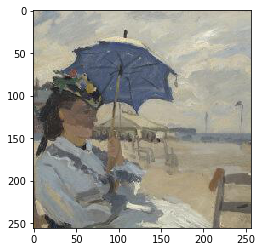

In [42]:
#Compare paintings by same artist to benchmark style scores

monet1 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-3951-00-000022-WZ-PYR.tif&CNT=1&JTL=1,0')
imshow(monet1)

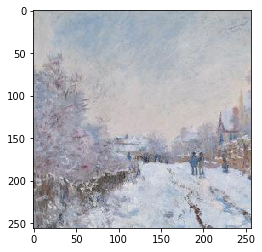

In [43]:
monet2 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6607-00-000013-WZ-PYR.tif&CNT=1&JTL=1,0')
imshow(monet2)

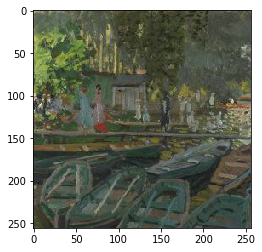

In [44]:
monet3 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6456-00-000031-WZ-PYR.tif&CNT=1&JTL=1,0')
imshow(monet3)

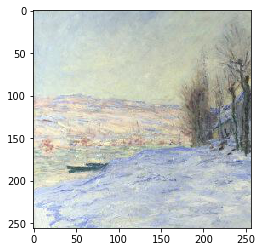

In [45]:
monet4 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-3262-00-000022-WZ-PYR.tif&CNT=1&JTL=1,0')
imshow(monet4)

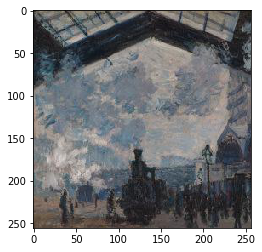

In [46]:
monet5 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6479-00-000032-WZ-PYR.tif&CNT=1&JTL=1,0')
imshow(monet5)

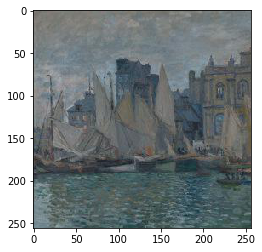

In [47]:
monet6 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6527-00-000020-WZ-PYR.tif&CNT=1&JTL=1,0')
imshow(monet6)

In [48]:
print('Content score: %f' % get_content_score(monet1, monet2))
print('Style score: %f' % get_style_score(monet1, monet2))

Content score: 6507.609474
Style score: 6574595.879490


In [49]:
print('Content score: %f' % get_content_score(monet1, monet3))
print('Style score: %f' % get_style_score(monet1, monet3))

Content score: 7478.367895
Style score: 6886482.599893


In [50]:
print('Content score: %f' % get_content_score(monet2, monet4))
print('Style score: %f' % get_style_score(monet2, monet4))

Content score: 6364.317895
Style score: 5473971.716003


In [51]:
print('Content score: %f' % get_content_score(monet4, monet5))
print('Style score: %f' % get_style_score(monet4, monet5))

Content score: 9332.186316
Style score: 16490055.217014


In [52]:
print('Content score: %f' % get_content_score(monet4, monet6))
print('Style score: %f' % get_style_score(monet4, monet6))

Content score: 6310.383684
Style score: 10579066.412256


In [53]:
print('Comparing monet5 and monet6')
print('Content score: %f' % get_content_score(monet5, monet6))
print('Style score: %f' % get_style_score(monet5, monet6))

Comparing monet5 and monet6
Content score: 7157.794737
Style score: 7475954.335653


In [54]:
# Lower scores = more similar
# Monet paintings 2 and 4 seem most visually similar to the eye in both content & style
# And indeed, have (2nd) lowest content score and lowest style score
# (Unsure why VGG considers paintings 4 and 6 to be equally similar in terms of content...)
# (Also unsure why paintings 5 and 6 are judged as so dissimilar in style to painting 4)
# (Could be darkness of color scheme rather than brush style)

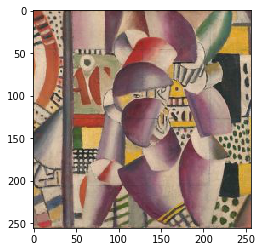

In [55]:
cubist1 = imageio.imread('https://news.artnet.com/app/news-upload/2014/11/Leger_Study-for-the-Acrobats_1918_ms-256x256.jpg')
imshow(cubist1)
#Artist: Fernand Leger, Style: Cubist

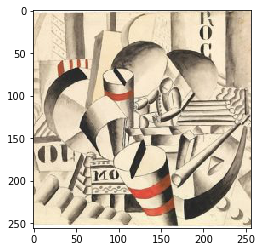

In [56]:
cubist2 = imageio.imread('https://news.artnet.com/app/news-upload/2014/11/the-tugboat-leger-1918-256x256.jpg')
imshow(cubist2)
#Artist: Fernand Leger, Style: Cubist

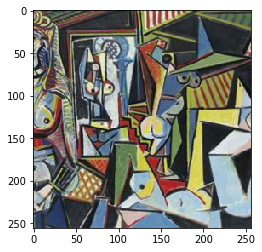

In [57]:
cubist3 = imageio.imread('https://news.artnet.com/app/news-upload/2015/05/pablo-picasso-les-femmes-dalger-version-o-e1432216064991-256x256.jpg')
imshow(cubist3)
#Artist: Pablo Picasso, Style: Cubist

In [58]:
print('Comparing cubist1 with cubist2')
print('Content score: %f' % get_content_score(cubist1, cubist2))
print('Style score: %f' % get_style_score(cubist1, cubist2))

Comparing cubist1 with cubist2
Content score: 18523.915789
Style score: 20763693.454736


In [59]:
print('Comparing cubist1 with monet1')
print('Content score: %f' % get_content_score(cubist1, monet1))
print('Style score: %f' % get_style_score(cubist1, monet1))

Comparing cubist1 with monet1
Content score: 13327.343158
Style score: 33228035.728886


In [60]:
print('Comparing cubist2 with monet1')
print('Content score: %f' % get_content_score(cubist2, monet1))
print('Style score: %f' % get_style_score(cubist2, monet1))

Comparing cubist2 with monet1
Content score: 14673.989474
Style score: 43465012.196718


In [61]:
print('Comparing cubist3 with monet1')
print('Content score: %f' % get_content_score(cubist3, monet1))
print('Style score: %f' % get_style_score(cubist3, monet1))

Comparing cubist3 with monet1
Content score: 17299.022105
Style score: 108225216.731523


In [62]:
# Analysis: Somehow, cubist1 and cubist2 have the least in common content-wise...
# (lending further credence to theory that color is playing a large role in content score evaluation)
# But style score is lower between cubist paintings than between cubist and impressionist (monet)

In [63]:
def convert_to_grayscale(img):
    new_img = np.copy(img)
    gray_vals = np.sum(img, axis=2) / 3
    new_img[:,:,0] = gray_vals
    new_img[:,:,1] = gray_vals
    new_img[:,:,2] = gray_vals
    
    return new_img

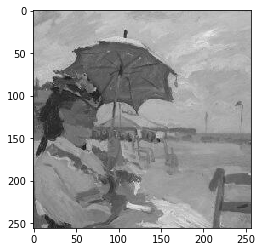

In [64]:
monet1_gray = convert_to_grayscale(monet1)
imshow(monet1_gray)

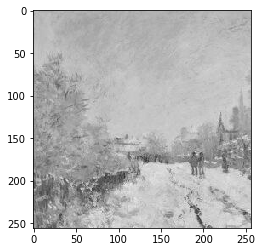

In [65]:
monet2_gray = convert_to_grayscale(monet2)
imshow(monet2_gray)

In [66]:
print('Comparing monet1 (gray) with monet2 (gray)')
print('Content score: %f' % get_content_score(monet1_gray, monet2_gray))
print('Style score: %f' % get_style_score(monet1_gray, monet2_gray))

Comparing monet1 (gray) with monet2 (gray)
Content score: 4474.041053
Style score: 3039247.570852


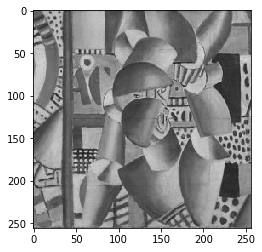

In [67]:
cubist1_gray = convert_to_grayscale(cubist1)
imshow(cubist1_gray)

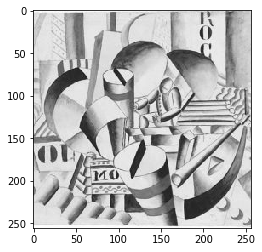

In [68]:
cubist2_gray = convert_to_grayscale(cubist2)
imshow(cubist2_gray)

In [69]:
print('Comparing cubist1 (gray) with cubist2 (gray)')
print('Content score: %f' % get_content_score(cubist1_gray, cubist2_gray))
print('Style score: %f' % get_style_score(cubist1_gray, cubist2_gray))

Comparing cubist1 (gray) with cubist2 (gray)
Content score: 13098.956842
Style score: 16313663.987645


In [70]:
print('Comparing cubist1 (gray) with monet1 (gray)')
print('Content score: %f' % get_content_score(cubist1_gray, monet1_gray))
print('Style score: %f' % get_style_score(cubist1_gray, monet1_gray))

Comparing cubist1 (gray) with monet1 (gray)
Content score: 7783.358947
Style score: 10496801.962399


In [71]:
print('Comparing cubist2 (gray) with monet1 (gray)')
print('Content score: %f' % get_content_score(cubist2_gray, monet1_gray))
print('Style score: %f' % get_style_score(cubist2_gray, monet1_gray))

Comparing cubist2 (gray) with monet1 (gray)
Content score: 12221.605263
Style score: 38210319.973147


In [72]:
# Analysis: When converting all images to grayscale, both content & style scores fall across the board,
# establishing that color does matter in NST.
# The results of each pairing is relatively the same relative to the other pairs though.
# (Perhaps because "brightness" of the color still matters in grayscale, as evidenced by the still substantial
# (difference in the colorings of cubist1_gray and cubist2_gray.)
# Therefore, since the ultimate goal is to rank results by scores RELATIVE to the other pairings, 
# color vs. grayscale in the user's image won't matter.

## The Search App

In [73]:
import urllib
import operator

In [74]:
print(urllib.quote('hello there'))

hello%20there


In [75]:
def fetch_tm_json(keywords, class_code):
    r = requests.get('https://developer.uspto.gov/ibd-api/v1/trademark/documents?text=%s&classCode=%s&start=0&rows=50' % (urllib.quote(keywords), class_code))
    return r.json()

In [76]:
test_json = fetch_tm_json('cat three gears', '020')
#print(test_json)

In [77]:
def get_serial_nos(json_resp):
    json_list = json_resp['response']['docs']
    serial_nos = []
    for i, app in enumerate(json_list):
        cfh = app['uspto_tm_document']['trademark_case_files']['trademark_case_file']['case_file_header']
        if 'design_mark' in cfh['mark'].keys():
            #print(i)
            if 'serial_number' in cfh.keys(): #Some apps don't have serial numbers?
                serial_nos.append(cfh['serial_number'])
    return serial_nos

In [78]:
print(get_serial_nos(test_json))

[87368206, 87434394, 87928270, 87410724, 87727510, 87602831, 87942972, 88087571, 87791956, 88023978, 87466836, 87498928, 87611404]


In [79]:
#Define a single composite metric / score for result rankings
def get_composite_score(content_score, style_score):
    COMP_CONTENT_FACTOR = 1.5 #Weight content slightly more heavily than style
    COMP_STYLE_FACTOR = 1.0
    
    return ((COMP_CONTENT_FACTOR * content_score) + (COMP_STYLE_FACTOR * style_score))

In [80]:
def find_results_and_rank(keywords, class_code, img):
    json_resp = fetch_tm_json(keywords, class_code)
    serial_nos = get_serial_nos(json_resp)
    print('Number of results: %s' % str(len(serial_nos)))
    
    #Process user image and retrieve activations (TODO: Only process img once)
    user_content_activ = process_and_get_content_activ(img)
    user_style_activs = process_and_get_style_activs(img)
    
    #Iterate serial nos, retrieve images, retrieve activations, compute scores
    tm_imgs = []
    score_dict = {}
    CONTENT_FACTOR = 100000
    STYLE_FACTOR = 100000000
    
    for i, serial_no in enumerate(serial_nos):
        
        tm_url = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_no)
        tm_img = imageio.imread(tm_url)
        tm_imgs.append(tm_img)
        #content_activs.append(process_and_get_content_activ(tm_img))
        #style_activs.append(process_and_get_style_activs(tm_img))
        
        score_dict[i] = {}
        
        content_activ = process_and_get_content_activ(tm_img)
        style_activs = process_and_get_style_activs(tm_img)
        
        content_cost = compute_content_cost(user_content_activ, content_activ)
        style_cost = sum_layer_style_costs(user_style_activs, style_activs)
        
        #content_scores.append(compute_content_cost(user_content_activ, content_activ))
        #style_scores.append(sum_layer_style_costs(user_style_activs, style_activs))
        
        content_score = (1.0 / content_cost) * CONTENT_FACTOR
        style_score = (1.0 / style_cost) * STYLE_FACTOR
        
        score_dict[i]['content_score'] = round(content_score, 2)
        score_dict[i]['style_score'] = round(style_score, 2)
        
        composite_score = get_composite_score(content_score, style_score)
        
        score_dict[i]['composite_score'] = round(composite_score, 2)
        score_dict[i]['image'] = tm_img
    
    #print(score_dict)
    #print(score_dict.items())
    return sorted(score_dict.items(), key=lambda kv: kv[1]['composite_score'], reverse=True)
    

(300, 300, 3)


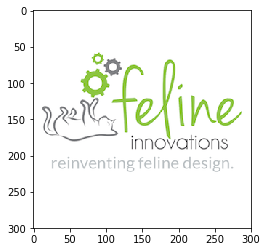

In [81]:
fi_logo = imageio.imread('fi_logo_300.png')[:,:,:3] #Discard 4th channel (alpha)
imshow(fi_logo)
print(fi_logo.shape)

In [82]:
unsorted_dict = {0: {'content_score': 9.180494020744245, 'composite_score': 20.357175220765832, 'style_score': 6.5864341896494665}, 1: {'content_score': 6.090049263370078, 'composite_score': 11.945282189512696, 'style_score': 2.810208294457578}, 2: {'content_score': 5.112391349575526, 'composite_score': 9.59671357073981, 'style_score': 1.9281265463765207}, 3: {'content_score': 6.144222361347538, 'composite_score': 10.633013793024032, 'style_score': 1.4166802510027259}, 4: {'content_score': 5.373975522276883, 'composite_score': 9.090121238127484, 'style_score': 1.0291579547121594}, 5: {'content_score': 4.137696980509095, 'composite_score': 6.988048590420113, 'style_score': 0.7815031196564697}, 6: {'content_score': 6.831694517687401, 'composite_score': 12.476726709122428, 'style_score': 2.229184932591327}, 7: {'content_score': 10.426299561414965, 'composite_score': 17.282913984106536, 'style_score': 1.6434646419840877}, 8: {'content_score': 7.842002309180764, 'composite_score': 13.709458299387089, 'style_score': 1.9464548356159441}, 9: {'content_score': 7.017352064985112, 'composite_score': 12.218010135915002, 'style_score': 1.691982038437332}, 10: {'content_score': 9.10689888811475, 'composite_score': 15.562400188491102, 'style_score': 1.9020518563189743}, 11: {'content_score': 3.3952821018383057, 'composite_score': 5.37604163403798, 'style_score': 0.28311848128052164}, 12: {'content_score': 4.252064914618985, 'composite_score': 6.934249067915399, 'style_score': 0.5561516959869217}}

sorted_dict = sorted(unsorted_dict.items(), key=lambda kv: kv[1]['composite_score'], reverse=True)
print(sorted_dict)

[(0, {'content_score': 9.180494020744245, 'composite_score': 20.357175220765832, 'style_score': 6.5864341896494665}), (7, {'content_score': 10.426299561414965, 'composite_score': 17.282913984106536, 'style_score': 1.6434646419840877}), (10, {'content_score': 9.10689888811475, 'composite_score': 15.562400188491102, 'style_score': 1.9020518563189743}), (8, {'content_score': 7.842002309180764, 'composite_score': 13.709458299387089, 'style_score': 1.9464548356159441}), (6, {'content_score': 6.831694517687401, 'composite_score': 12.476726709122428, 'style_score': 2.229184932591327}), (9, {'content_score': 7.017352064985112, 'composite_score': 12.218010135915002, 'style_score': 1.691982038437332}), (1, {'content_score': 6.090049263370078, 'composite_score': 11.945282189512696, 'style_score': 2.810208294457578}), (3, {'content_score': 6.144222361347538, 'composite_score': 10.633013793024032, 'style_score': 1.4166802510027259}), (2, {'content_score': 5.112391349575526, 'composite_score': 9.596

In [83]:
fi_results = find_results_and_rank('cat three gears', '020', fi_logo)

Number of results: 13


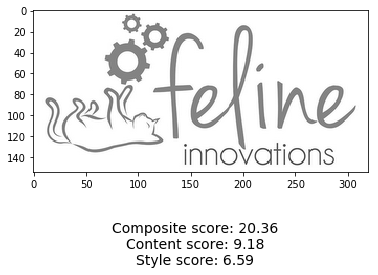

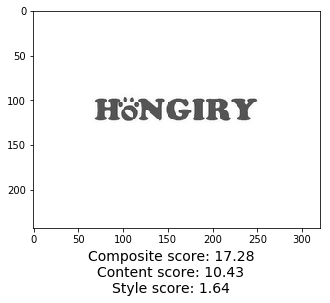

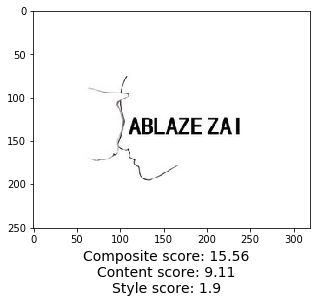

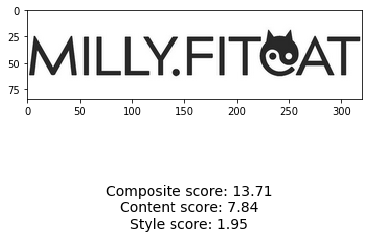

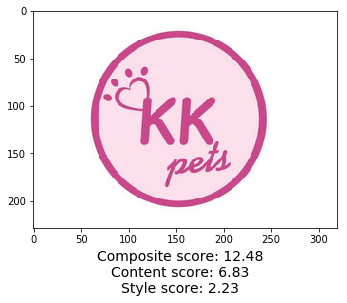

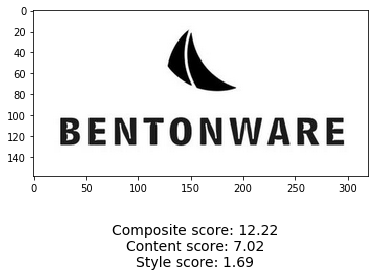

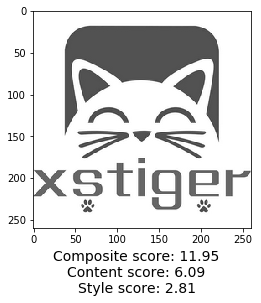

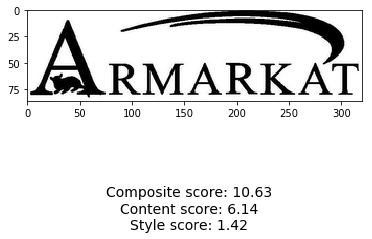

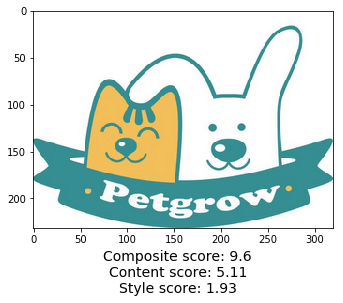

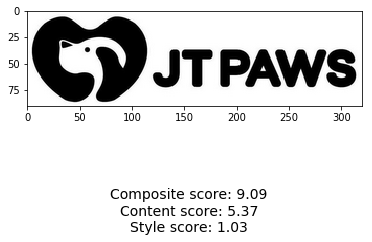

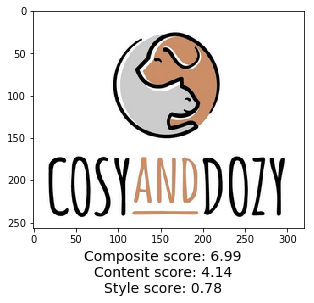

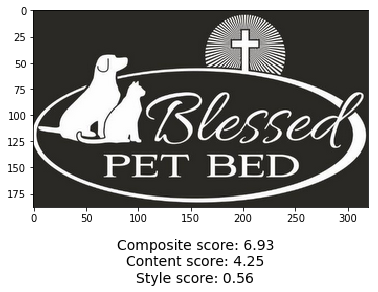

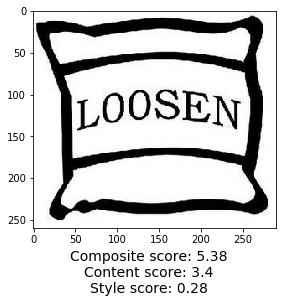

In [84]:
for entry in fi_results:
    _, score_dict = entry
    fig = plt.figure()
    imshow(score_dict['image'])
    txt = 'Composite score: %s\nContent score: %s\nStyle score: %s' % (score_dict['composite_score'], score_dict['content_score'], score_dict['style_score'])
    fig.text(.5, -0.1, txt, ha='center', fontsize=14)
    #print('Composite score: %s' % score_dict['composite_score'])
    #print('Content score: %s' % score_dict['content_score'])
    #print('Style score: %s' % score_dict['style_score'])